# Q-CTRL hackathon challenge for the IV Quantum Computing Workshop 

**Using quantum control to improve a qubit in the cloud**

Welcome to the Q-CTRL hackathon problem! 

Here at Q-CTRL we use quantum control to solve the hardest problems facing quantum technologies. To learn more about us and our products check out our [website](https://q-ctrl.com/).

In this problem, we're challenging you to use our product [Boulder Opal](https://q-ctrl.com/products/boulder-opal/) to improve the performance of a qubit in the cloud. By participating in our challenge you will learn about the real problems facing the quantum computing industry today and how you can help to solve them!

## What is wrong with current quantum computers?

You've probably heard about the great potential applications that quantum computers can solve, factorizing prime numbers, solving quantum chemistry problems, and accelerating machine learning algorithms (go to [Q-CTRL's Learning Center](https://q-ctrl.com/learning-center/) to learn more). IBM has released a commercial quantum computer with the [IBM Quantum experience](https://quantum-computing.ibm.com/) and Google has demonstrated a [quantum computer has an advantage over a classical computer](https://www.nature.com/articles/s41586-019-1666-5) for the problem of sampling from a specific probability distribution.

So why aren't quantum computers being used to solve useful problems today?

The answer is our current qubits have high error rates due to *noise from the environment*. 

To put this problem into perspective, a transistor (the building block of a classical computer) typically has 1 error in every 1 billion years, while a qubit typically has an error every 0.001 seconds. That's a huge difference.

The big challenge facing the quantum computing industry is to make quantum computers with large numbers of qubits with much lower error rates. 

By solving Q-CTRL's hackathon problem you will use what you learned in our lectures about modeling and simulating a quantum system to design a quantum control procedure to reduce the errors and imperfections on a realistic qubit.

## The challenge

Your challenge is to provide two pulses that implement a high fidelity NOT gate and Hadamard gate on our qubit in the cloud. The qubit in the cloud models a superconducting qubit. 

You must also write a 2-page report on how you used quantum control, with Q-CTRL's [Boulder Opal](https://q-ctrl.com/products/boulder-opal/), to discover and implement these pulses. 

Don't worry if you're not familiar with the physics of superconducting qubits (or physics in general), this notebook contains the code used in our lectures and will give you a great introduction to the problem. 

## Submission

We recommend doing your submission through a Github repository. You can create an account by going to [GitHub's home page](https://github.com/). We recommend using [the Github GUI client](https://desktop.github.com/) to make life a bit easier if you're not used to using a command line.

Make a repository named `ivqcw-<team_name>` with a description `IV-QCW Hackathon <team_name> entry`. Where `<team_name>` is your team name. 

In the root folder should be three essential files:

1. `not_gate_pulse.json` which contains a dictionary with the `duration` and `values` of your best NOT gate.
2. `h_gate_pulse.json` which contains a dictionary with the `duration` and `values` of your best Hadamard gate.
3. `challenge_summary.pdf` which should be a 2 page description on how you used quantum control and Boulder Opal to create pulses that implement high fidelity NOT and Hadamard gates on the qubit in the cloud.

A code snippet showing how to generate correctly formated JSON files is below.

The competition will primarily be judged on these three documents. You are also welcome to include other code and documents to support your entry. This may be looked at to differentiate entries that are close.

When you've completed your submission send an email to [andre.carvalho@q-ctrl.com](mailto:andre.carvalho@q-ctrl.com) with `Q-CTRL IV-QCW Hackathon <team_name> entry` in the subject field. In the body of the email provide a link to the GitHub repository with your entry along with the names of all the members of your team and their contact details (preferably an email). 

## Judging

Judging will occur over the next few days after the competition. Your submission will be judged based on two criteria:

1. The first criterion is eliminatory and consists in evaluating the quality of your gates. The quality will be assessed using a simulation of the qubit-in-the-cloud with your optimized pulses and accurately measuring the fidelity with respect to the appropriate gate. To be considered for the next judging criterion, your entry must contain a control pulse that creates a gate with fidelity larger than $90 \%$.  

2. The other half of the assessment will depend on the quality of your approach and clarity of your solution finding techniques. We will consider if your method is generalizable to any gate, whether your approach scales to multi-qubit gates, etc.

An email will be sent to all teams that entered with some feedback on your entry and how you placed. 

## The prizes

The top 3 entries will receive:

- 1st place: A 1-year group subscription to Boulder Opal; a $50 Amazon gift card, and a Q-CTRL swag bag for each team member.

- 2nd place: A $50 Amazon gift card and a Q-CTRL swag bag for each team member.

- 3rd place: A Q-CTRL swag bag for each team member.

Winning teams will be contacted after the competition to get delivery details for the prizes. 


## Getting started with Boulder Opal

To get started with the challenge, you'll need to get access to Boulder Opal. This is done in two easy steps:
1. Go to the [Boulder Opal sign up page](https://app.q-ctrl.com/signup) then follow the instructions to create an account.
2. Go to the [Boulder Opal documentation](https://docs.q-ctrl.com/) and follow the [get started guide](https://docs.q-ctrl.com/boulder-opal/get-started) to install the `qctrl` and `qctrlvisualizer` Python packages on your machine.

If you've installed Boulder Opal correctly you should be able to load the packages required to run the rest of this notebook:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()

## Back to the hackathon problem: quantum control approaches

There are many different ways to use quantum control to improve the performance of a realistic qubit. We discussed some of them in our lectures and you can find a detailed explanation on [how to choose an optimization strategy in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/choosing-a-control-design-optimization-strategy-in-boulder-opal) in our documentation. 

It's up to you to decide which approach interests you the most but, given that you don't know much about the model for the qubit in the cloud, we strongly recommend using a closed-loop optimization method for this problem.

### The challenge

The challenge is to use Boulder Opal to create pulses that implement high fidelity Hadamard and NOT gates on the provided qubit in the cloud. 

### The qubit in the cloud

The qubit in the cloud for the challenge itself *is even more complicated and realistic* than the models discussed in the first lecture. It contains all the effects that the more realistic qubit has, along with a few additional complications that a real superconducting qubit faces. 

In what follows we will show you how to interact with the qubit in the cloud. You'll learn how to create a series of controls (pulses), send them to the qubit in the cloud, extract measurement results, and analyze them.

We begin by establishing some parameters for our pulses:
- `control_count`: How many controls we create (maximum 100).
- `segment_count`: How many segments each pulse is split into (maximum 256).
- `duration`: The duration (in ns) of each pulse (maximum 300).
- `shot_count`: How many projective measurements we take at the end of each control (maximum 10000).

You will probably want to change these values later depending on how you approach the challenge. For instance, the larger the `shot_count` is, the more measurements we get out of the qubit for each control (we only keep it small here so that the experiment results are easier to visualize).


In [2]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

We now create a list of controls to send to the qubit. Each of them is a dictionary with a `duration` (how long the pulse is, in nanoseconds, up to a maximum of 300) and an array of (complex) `values` indicating the strength of the pulse in piecewise-constant intervals (with maximum absolute value 1). Here we use random pulses, so we do not expect them to perform very well at all or implement any particular gate.

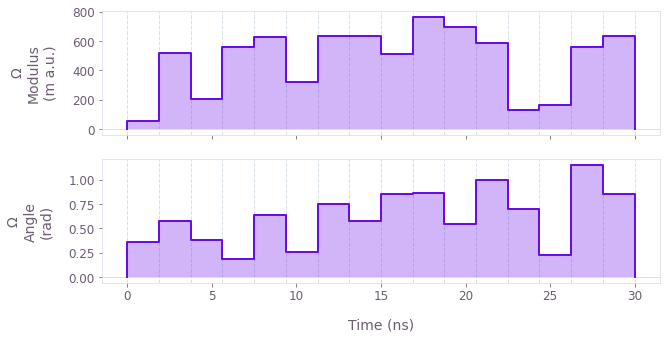

In [3]:
controls = []
for k in range(control_count):
    # Create a random string of complex numbers for each controls.
    real_part = np.random.random(size=[segment_count])
    imag_part = np.random.random(size=[segment_count])
    values = 0.15 * k * (real_part + 1j * imag_part)

    controls.append({"duration": duration, "values": values})

# Plot the last control as an example.
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": duration / segment_count / 1e9, "value": value}
            for value in values
        ]
    },
    unit_symbol=" a.u.",
    two_pi_factor=False,
)

We can now send those controls to the qubit and get back the results of applying each one of them. This is done using the function `qctrl.functions.calculate_hackathon_measurements`. We put the returned object in `experiment_results`.

In [4]:
# Obtain the results of the experiment.
experiment_results = qctrl.functions.calculate_hackathon_measurements(
    controls=controls, shot_count=shot_count
)

Your task calculate_hackathon_measurements (action_id="691059") has completed.


What we are interested in are the results of the measurements on the qubit, which are in `experiment_results.measurements`. This is a list containing, for each control that we have sent to the qubit, the result of `shot_count` measurements, that is, whether the qubit was found to be in state $|0\rangle$, $|1\rangle$, or $|2\rangle$ (Yes! The superconducting "qubit" is only approximately a qubit and, in reality, has multiple levels.)

In [5]:
measurements = experiment_results.measurements
for k, measurement_counts in enumerate(measurements):
    print(f"control #{k}: {measurement_counts}")

control #0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
control #1: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
control #2: [0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]
control #3: [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]
control #4: [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1]


In [6]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(f"control #{k}: P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}")

control #0: P(|0>) = 1.00, P(|1>) = 0.00, P(|2>) = 0.00
control #1: P(|0>) = 0.78, P(|1>) = 0.22, P(|2>) = 0.00
control #2: P(|0>) = 0.41, P(|1>) = 0.59, P(|2>) = 0.00
control #3: P(|0>) = 0.34, P(|1>) = 0.66, P(|2>) = 0.00
control #4: P(|0>) = 0.72, P(|1>) = 0.28, P(|2>) = 0.00


Here is a block of code that combines all the elements above, runs various repetitions of a random pulse on the qubit in the cloud, and returns the corresponding probabilities. Remember that in our first lecture we showed that applying pulses repeatedly is a good way to amplify the error signals and obtain better gates.

In [7]:
repetitions = [1, 4, 16, 32, 64]

# Create a random string of complex numbers for the control,
# but set a different repetition_count for each control. The
# repetition_count (maximum 64) controls how many times the
# control is applied in sequence before the measurements are
# made.
real_part = np.random.random(size=[segment_count])
imag_part = np.random.random(size=[segment_count])
values = 0.5 * (real_part + 1j * imag_part)

controls = [
    {"duration": duration, "values": values, "repetition_count": repetition_count}
    for repetition_count in repetitions
]

experiment_results = qctrl.functions.calculate_hackathon_measurements(
    controls=controls, shot_count=shot_count
)

for repetition_count, measurement_counts in zip(
    repetitions, experiment_results.measurements
):
    p0 = measurement_counts.count(0) / shot_count
    p1 = measurement_counts.count(1) / shot_count
    p2 = measurement_counts.count(2) / shot_count
    print(
        f"With {repetition_count:2d} repetitions: "
        f"P(|0>) = {p0:.2f}, P(|1>) = {p1:.2f}, P(|2>) = {p2:.2f}"
    )

Your task calculate_hackathon_measurements (action_id="691060") has completed.
With  1 repetitions: P(|0>) = 0.16, P(|1>) = 0.84, P(|2>) = 0.00
With  4 repetitions: P(|0>) = 0.19, P(|1>) = 0.81, P(|2>) = 0.00
With 16 repetitions: P(|0>) = 0.25, P(|1>) = 0.75, P(|2>) = 0.00
With 32 repetitions: P(|0>) = 0.44, P(|1>) = 0.56, P(|2>) = 0.00
With 64 repetitions: P(|0>) = 0.19, P(|1>) = 0.81, P(|2>) = 0.00


Now that you know how to run experiments on the qubit in the cloud, we suggest you look at this [user guide](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-automate-closed-loop-hardware-optimization) to see how you could implement a closed-loop optimization. Once you are happy with the performance of the gates you optimized, you can use the code below to export a JSON file with your results.

In [8]:
import jsonpickle.ext.numpy as jsonpickle_numpy
import jsonpickle

jsonpickle_numpy.register_handlers()

not_control = {"duration": 12.3, "values": np.array([0.5, -0.5, 1j * 0.2])}
json_not_control = jsonpickle.encode(not_control)
with open("not_control.json", "w") as file:
    file.write(json_not_control)

### You're now set to solve our hackathon problem. Good luck!